# Анализ данных в задаче кредитного скоринга

Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.

При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.

При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость.

Выполненное задание необходимо представить в ipython-ноутбука.

### Описание данных

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.proportion import proportion_confint

In [2]:
credit_story = pd.read_csv('data/credit_card_default_analysis.csv')
credit_story.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [3]:
pd.set_option('display.max_columns', None)
credit_story.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Вопросы:

**1.** Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

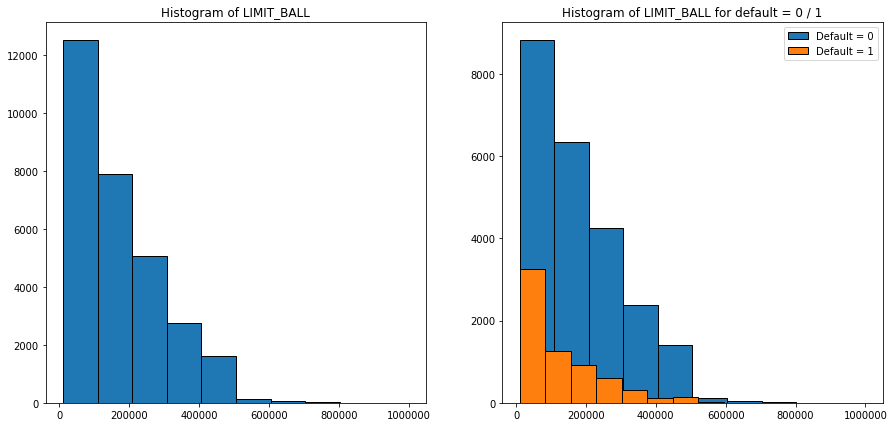

In [4]:
plt.figure(1, figsize=(15,7))

plt.subplot(121)
plt.title('Histogram of LIMIT_BALL')
plt.hist(credit_story['LIMIT_BAL'], edgecolor='k')

plt.subplot(122)
plt.title('Histogram of LIMIT_BALL for default = 0 / 1')
plt.hist(credit_story.LIMIT_BAL.loc[credit_story.default == 0], edgecolor='k', label='Default = 0')
plt.hist(credit_story.LIMIT_BAL.loc[credit_story.default == 1], edgecolor='k', label='Default = 1')
plt.legend()

Проверка гипотезы о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.

- H0: медианные значения равны
- H1: медианные значения отличаются

In [5]:
lim_bal_0 = credit_story.LIMIT_BAL.loc[credit_story.default == 0]
lim_bal_1 = credit_story.LIMIT_BAL.loc[credit_story.default == 1]

print('Median LIMIT_BAL for default = 0: %.0f' % lim_bal_0.median())
print('Median LIMIT_BAL for default = 1: %.0f' % lim_bal_1.median())

Median LIMIT_BAL for default = 0: 150000
Median LIMIT_BAL for default = 1: 90000


#### Биномиальное распределение

In [6]:
def zconfint_binom(n, p, alpha=0.05):
    q = 1 - p
    m = n * p
    var = n * p * q
    z_stat = stats.norm.ppf(1 - alpha / 2)
    l_bound = int(round(m - z_stat * np.sqrt(var)))
    u_bound = int(round(m + z_stat * np.sqrt(var)))
    return (l_bound, u_bound)

In [7]:
lim_bal_0_s = np.sort(lim_bal_0.values)
lim_bal_1_s = np.sort(lim_bal_1.values)

l_ind_0, u_ind_0 = zconfint_binom(len(lim_bal_0_s), 0.5)
l_ind_1, u_ind_1 = zconfint_binom(len(lim_bal_1_s), 0.5)

print('Conf. int. median LIMIT_BAL for default = 0: [%d, %d]' % (lim_bal_0_s[l_ind_0], lim_bal_0_s[u_ind_0]))
print('Conf. int. median LIMIT_BAL for default = 1: [%d, %d]' % (lim_bal_1_s[l_ind_1], lim_bal_1_s[u_ind_1]))

Conf. int. median LIMIT_BAL for default = 0: [150000, 150000]
Conf. int. median LIMIT_BAL for default = 1: [80000, 90000]


#### Бутстрэп

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
np.random.seed(0)

lim_bal_0_bs_med = list(map(np.median, get_bootstrap_samples(lim_bal_0.values, 100)))
lim_bal_1_bs_med = list(map(np.median, get_bootstrap_samples(lim_bal_1.values, 100)))

bnd_0 = stat_intervals(lim_bal_0_bs_med, 0.05)
bnd_1 = stat_intervals(lim_bal_1_bs_med, 0.05)

print('Conf. int. median LIMIT_BAL for default = 0: [%d, %d]' % (bnd_0[0], bnd_0[1]))
print('Conf. int. median LIMIT_BAL for default = 1: [%d, %d]' % (bnd_1[0], bnd_1[1]))

Conf. int. median LIMIT_BAL for default = 0: [150000, 150000]
Conf. int. median LIMIT_BAL for default = 1: [80000, 90000]


Интервальные оценки медианы не совпадают. Можно сделать вывод что заемщики которые не возвращают кредит обычно берут меньшую сумму

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.
- H0: распределения выборок полностью равны
- H1: распределения выборок отличаются на величину сдвига

In [11]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [12]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [13]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [14]:
def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [15]:
print('p-value: %f' % permutation_test(lim_bal_0, lim_bal_1, max_permutations=1000))

p-value: 0.001000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05, результат является практически значимым.

**2.** Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

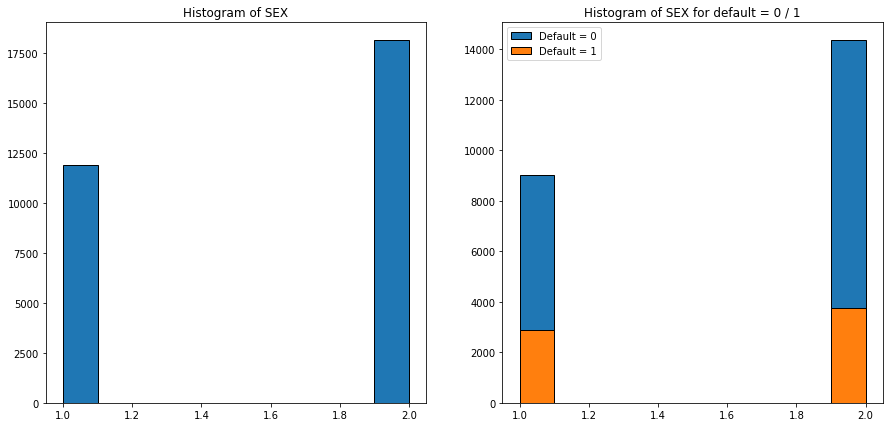

In [16]:
plt.figure(1, figsize=(15,7))

plt.subplot(121)
plt.title('Histogram of SEX')
plt.hist(credit_story['SEX'], edgecolor='k')

plt.subplot(122)
plt.title('Histogram of SEX for default = 0 / 1')
plt.hist(credit_story.SEX.loc[credit_story.default == 0], edgecolor='k', label='Default = 0')
plt.hist(credit_story.SEX.loc[credit_story.default == 1], edgecolor='k', label='Default = 1')
plt.legend()

Женщины более склонны к невозврату кредита, чем мужчины.

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 
Построим доверительные интервалы для доли вернувших, не вернувших и для их разности.

In [17]:
sex_0 = credit_story.SEX.loc[credit_story.default == 0].values
sex_1 = credit_story.SEX.loc[credit_story.default == 1].values

m_to_w_0 = np.where(sex_0 == 1)[0].shape[0] / sex_0.shape[0]
m_to_w_1 = np.where(sex_1 == 1)[0].shape[0] / sex_1.shape[0]

print('Prop. of men for default = 0: %.4f' % m_to_w_0)
print('Prop. of men for default = 1: %.4f' % m_to_w_1)

Prop. of men for default = 0: 0.3859
Prop. of men for default = 1: 0.4329


Используем доверительный интервал на основе нормального распределения

In [18]:
conf_int_0 = proportion_confint(np.where(sex_0 == 1)[0].shape[0], sex_0.shape[0])
conf_int_1 = proportion_confint(np.where(sex_1 == 1)[0].shape[0], sex_1.shape[0])

print('Conf. int. for prop. of men or default = 0: [%.4f, %.4f]' % conf_int_0)
print('Conf. int. for prop. of men or default = 1: [%.4f, %.4f]' % conf_int_1)

Conf. int. for prop. of men or default = 0: [0.3796, 0.3921]
Conf. int. for prop. of men or default = 1: [0.4210, 0.4449]


Как видно из интервальных оценок, сами интервалы не пересекаются, следовательно гендерный состав различается.
Построим доверительный интервал для разности двух долей независимых выборок.

In [19]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)

In [20]:
print('Conf. int. for difference: [%f, %f]' % proportions_confint_diff_ind(np.abs(sex_0-2), np.abs(sex_1-2)))

Conf. int. for difference: [-0.060548, -0.033635]


Используем статистический Z-критерий для доли для двух независимых выборок.

- H0: гендерный состав не отличается
- H1: гендерный состав отличается

In [21]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [22]:
def proportions_diff_z_test(z_stat, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [23]:
print('p-value: %.15f' % proportions_diff_z_test(proportions_diff_z_stat_ind(np.abs(sex_0-2), np.abs(sex_1-2))))

p-value: 0.000000000004473


Гипотеза о равенстве гендерного распределния отвергается. Данный результат явлется практически значимым

**3.** Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

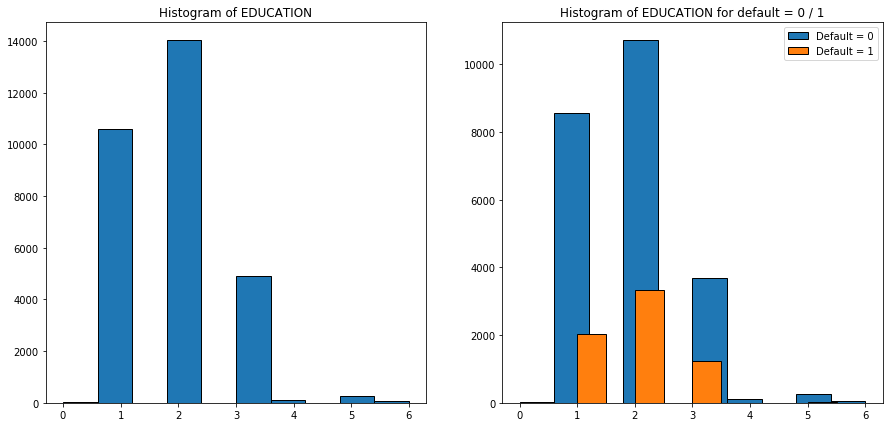

In [24]:
plt.figure(1, figsize=(15,7))

plt.subplot(121)
plt.title('Histogram of EDUCATION')
plt.hist(credit_story['EDUCATION'], edgecolor='k')

plt.subplot(122)
plt.title('Histogram of EDUCATION for default = 0 / 1')
plt.hist(credit_story.EDUCATION.loc[credit_story.default == 0], edgecolor='k', label='Default = 0')
plt.hist(credit_story.EDUCATION.loc[credit_story.default == 1], edgecolor='k', label='Default = 1')
plt.legend()

В основном берут кредиты люди с образованием магистра и бакалавра. Принципиальная разница между распределниями тех, кто вернул, и тех, кто нет, не наблюдается.

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг. Построим график долей возврата кредитов.

Prop. of def.=0 for education=0: 1.00
Prop. of def.=0 for education=1: 0.81
Prop. of def.=0 for education=2: 0.76
Prop. of def.=0 for education=3: 0.75
Prop. of def.=0 for education=4: 0.94
Prop. of def.=0 for education=5: 0.94
Prop. of def.=0 for education=6: 0.84


[0, 6, 0.5, 1]

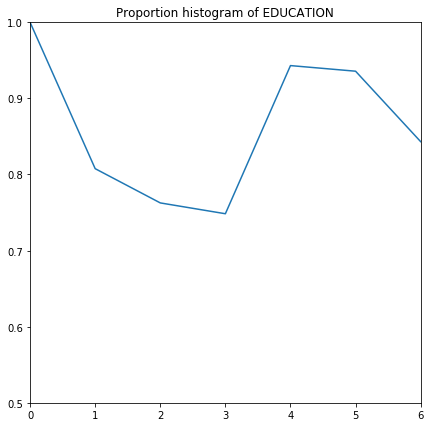

In [25]:
edu = credit_story.EDUCATION
edu_0 = credit_story.EDUCATION.loc[credit_story.default == 0]
edu_1 = credit_story.EDUCATION.loc[credit_story.default == 1]

edu_prop = np.empty( (len(np.unique(edu_0)), 2) )
for i, ed_val in enumerate(np.unique(edu)):
    edu_prop[i, 0] = ed_val
    edu_prop[i, 1] = edu_0[edu_0 == ed_val].shape[0] / (edu_0[edu_0 == ed_val].shape[0] + edu_1[edu_1 == ed_val].shape[0])

for ed_val, prop in edu_prop:
    print('Prop. of def.=0 for education=%d: %.2f' % (ed_val, prop))

plt.figure(1, figsize=(7,7))
plt.title('Proportion histogram of EDUCATION')
plt.plot(edu_prop[:,0], edu_prop[:,1])
plt.axis([0, 6, 0.5, 1])

Исходя из графика видно, что распределние не является равномерным, следовательно, образование влияет на то, вернёт ли человек долг. Реже всего возвращают долги категории 2 и 3 (бакалавры и выпускники школ). Возвращают практически все долги только люди с докторской степенью.

Произведём строгую проверку на соответствие данного распределения равномерному с помощью критерия согласия Пирсона хи-квадрат.¶

- H0: рассматривая величина имеет равномерное распределение
- H1: H0 не верна

Посчитаем среднее значение доли возврата кредитов среди различных уровней образования. Будем использовать эту оценку для построения ожидаемого равномерного распределения.

In [26]:
prop_mean = edu_prop[:,1].mean()
print('Mean proportion value: %.2f' % prop_mean)

Mean proportion value: 0.86


In [27]:
edu_num_0 = np.array([edu_0[edu_0 == ed_val].shape[0] for ed_val in range(7)])
edu_num_1 = np.array([edu_1[edu_1 == ed_val].shape[0] for ed_val in range(7)])
edu_num = edu_num_0 + edu_num_1

for i in range(7):
    print('Edu lvl %d: %d / %d | %d' % (i, edu_num_0[i], edu_num_1[i], edu_num[i]))
print('Legend: deafault = 0 / default = 1 | total')

Edu lvl 0: 14 / 0 | 14
Edu lvl 1: 8549 / 2036 | 10585
Edu lvl 2: 10700 / 3330 | 14030
Edu lvl 3: 3680 / 1237 | 4917
Edu lvl 4: 116 / 7 | 123
Edu lvl 5: 262 / 18 | 280
Edu lvl 6: 43 / 8 | 51
Legend: deafault = 0 / default = 1 | total


Составим таблицу сопряжённости "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

In [28]:
exp_freq = np.array([prop_mean * edu_num[i] for i in range(7)])

for i in range(7):
    print('Edu lvl %d: %d / %d | %d' % (i, exp_freq[i], edu_num_0[i], edu_num_0[i] - exp_freq[i]))
print('Legend: exp freq / obs freq = 1 | delta')

Edu lvl 0: 12 / 14 | 1
Edu lvl 1: 9134 / 8549 | -585
Edu lvl 2: 12107 / 10700 | -1407
Edu lvl 3: 4243 / 3680 | -563
Edu lvl 4: 106 / 116 | 9
Edu lvl 5: 241 / 262 | 20
Edu lvl 6: 44 / 43 | -1
Legend: exp freq / obs freq = 1 | delta


In [29]:
stats.chisquare(edu_num_0, exp_freq, ddof = 1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

Гипотеза о том, что величина имеет равномерное распределение отвергается с очень высокой долей вероятности.
Результат имеет практическую значимость для выдачи кредита, доли возврата значимо отличаются для разных уровней образования.

**4.** Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

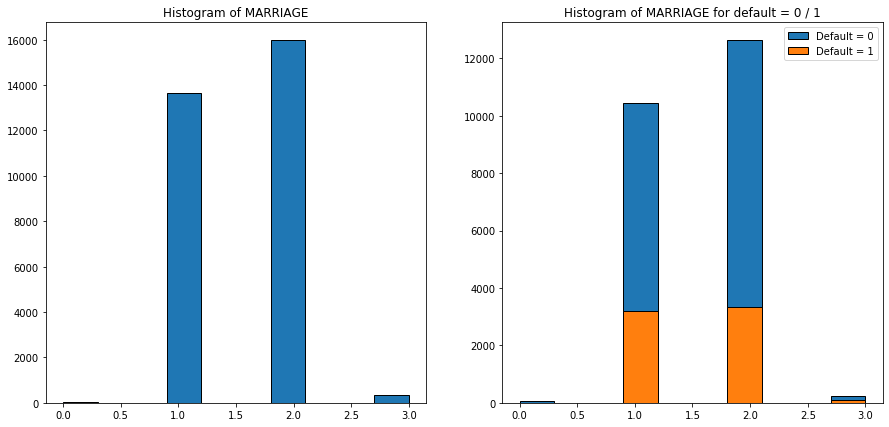

In [30]:
plt.figure(1, figsize=(15,7))

plt.subplot(121)
plt.title('Histogram of MARRIAGE')
plt.hist(credit_story['MARRIAGE'], edgecolor='k')

plt.subplot(122)
plt.title('Histogram of MARRIAGE for default = 0 / 1')
plt.hist(credit_story.MARRIAGE.loc[credit_story.default == 0], edgecolor='k', label='Default = 0')
plt.hist(credit_story.MARRIAGE.loc[credit_story.default == 1], edgecolor='k', label='Default = 1')
plt.legend()

Доли невозвратов среди женатых и холостых людей различается незначительно

Проверим, как связан семейный статус с индикатором дефолта.

In [31]:
mar = credit_story.MARRIAGE
mar_0 = credit_story.MARRIAGE.loc[credit_story.default == 0]
mar_1 = credit_story.MARRIAGE.loc[credit_story.default == 1]

print('Value counts for marriage:')
mar.value_counts()

Value counts for marriage:


2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [32]:
conf_table = np.empty( (len(mar.value_counts()), 2) )
for i in range(len(mar.value_counts())):
    conf_table[i, 0] = len(mar_0.loc[mar_0 == i])
    conf_table[i, 1] = len(mar_1.loc[mar_1 == i])
conf_table

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

In [33]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [34]:
print('V Cramer stat value: %.4f' % cramers_stat(conf_table))

V Cramer stat value: 0.0345


Коэффициент Крамера принимает значение, близкое к нулю, когда взаимосвязь отсутствует.
Практическая значимость в данном результате также присутствует, т.к. исходя из этих данных нет разницы в том, с каким статусом MARRIAGE приходит человек за кредитом.

**5.** Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

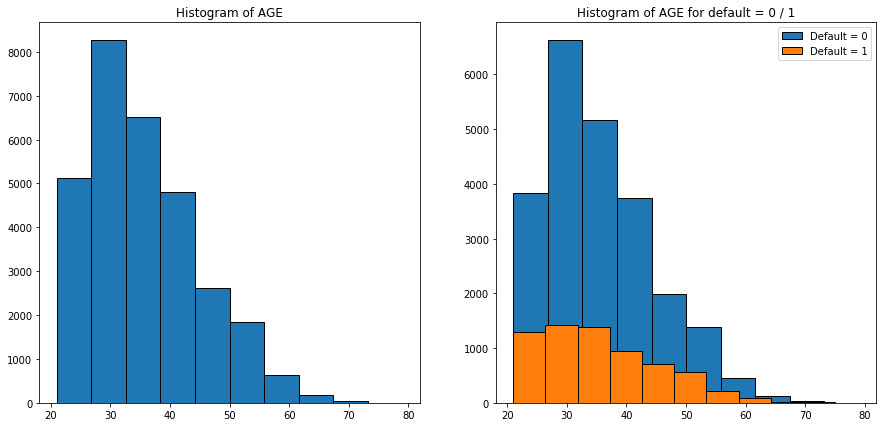

In [35]:
plt.figure(1, figsize=(15,7))

plt.subplot(121)
plt.title('Histogram of AGE')
plt.hist(credit_story['AGE'], edgecolor='k')

plt.subplot(122)
plt.title('Histogram of AGE for default = 0 / 1')
plt.hist(credit_story.AGE.loc[credit_story.default == 0], edgecolor='k', label='Default = 0')
plt.hist(credit_story.AGE.loc[credit_story.default == 1], edgecolor='k', label='Default = 1')
plt.legend()

Молодые люди более склонны не возвращать кредиты.

Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

- H0: медианные значения равны
- H1: медианные значения отличаются

In [36]:
age_0 = credit_story.AGE.loc[credit_story.default == 0]
age_1 = credit_story.AGE.loc[credit_story.default == 1]

print('Median AGE for default = 0: %.0f' % age_0.median())
print('Median AGE for default = 1: %.0f' % age_1.median())

Median AGE for default = 0: 34
Median AGE for default = 1: 34


Доверительный интервал для медианы на основе бутстрепа.

In [37]:
np.random.seed(0)

age_0_bs_med = list(map(np.median, get_bootstrap_samples(age_0.values, 100)))
age_1_bs_med = list(map(np.median, get_bootstrap_samples(age_1.values, 100)))

bnd_0 = stat_intervals(age_0_bs_med, 0.05)
bnd_1 = stat_intervals(age_1_bs_med, 0.05)

print('Conf. int. median AGE for default = 0: [%f, %f]' % (bnd_0[0], bnd_0[1]))
print('Conf. int. median AGE for default = 1: [%f, %f]' % (bnd_1[0], bnd_1[1]))

Conf. int. median AGE for default = 0: [34.000000, 34.000000]
Conf. int. median AGE for default = 1: [34.000000, 35.000000]


Как видно, интервальные оценки для медианы пересекаются.

Построим интервальную оценку для разности медиан.

In [38]:
print('Difference between medians: %f' % (np.median(age_0) - np.median(age_1)))

Difference between medians: 0.000000


In [39]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(age_0_bs_med, age_1_bs_med)))

In [40]:
stat_int = stat_intervals(delta_median_scores, 0.05)
print('95%% conf. int. for the difference between medians: [%f, %f]' % (stat_int[0], stat_int[1]))

95% conf. int. for the difference between medians: [0.000000, 1.000000]


Поскольку доверительный интервал содержит ноль, значения медиан не различаются.

Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.
Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.
- H0: распределения выборок полностью равны
- H1: распределения выборок отличаются на величину сдвига

In [41]:
print('p-value: %f' % permutation_test(age_0, age_1, max_permutations=1000))

p-value: 0.014000


P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.
Результат является практически значимым.